# Load libraries

In [4]:
if (!requireNamespace("dplyr", quietly = TRUE))
    install.packages("dplyr")
library(dplyr)

In [5]:
if (!requireNamespace("rtracklayer", quietly = TRUE)) BiocManager::install("rtracklayer")
library(rtracklayer)

In [2]:
library(Seurat)
library(Signac)
library(Matrix)
library(readr)
library(ggplot2)
library(data.table)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)

# Step 1: Load sparse matrix and convert to full matrix

Use the dataset: "PBMCs 3k cells from a healthy donor"
* Use the material provided as part of the exam.

Matrix conversion
* Use the Matrix R package to convert the sparse matrix into a full matrix.
* Save the result as a data.table object.


In [3]:
data_path <- "Data/matrix/"

In [4]:
matrix <- readMM(file = paste0(data_path, "matrix.mtx.gz"))
features <- read_tsv(file = paste0(data_path, "features.tsv.gz"), 
         col_names = c("id", "name", "type", "chr", "start", "end"), show_col_types = F)
barcodes <- read_tsv(file = paste0(data_path, "barcodes.tsv.gz"), col_names = F, show_col_types = F) 

In [5]:
colnames(matrix) <- barcodes$X1
rownames(matrix) <- features$id
matrix <- as.matrix(matrix)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


In [6]:
dt <- as.data.table(matrix, row.names = rownames(matrix))
dt[, id := rownames(matrix)]
setcolorder(dt, c("id", setdiff(names(dt), "id")))

# Step 2: Split gene expression and ATAC-seq data

From the data.table object, separate:
* Gene expression data (rows labelled with Ensembl gene IDs, e.g., ENSG00000243485)
* ATAC-seq peak data (rows labelled with genomic coordinates, e.g., chrN:NNNN-NNNN)


In [7]:
dt_genes <- dt[grepl("ENSG", dt$id)]
dt_atac <- rbind(dt[grepl("chr", dt$id)])

# Step 3: Summarize Data

For each dataset (expression and peaks), compute the column-wise sum to produce:
* A single vector of total expression per gene
* A single vector of total chromatin accessibility per peak region

In [8]:
genes_summary <- dt_genes[, rowSums(.SD), .SDcols = -"id"]
names(genes_summary) <- dt_genes$id
#genes_summary[1:5]

In [9]:
atac_summary <- dt_atac[, rowSums(.SD), .SDcols = -"id"]
names(atac_summary) <- dt_atac$id
#atac_summary[1:5]

# Step 4: Create GenomicRanges

* Convert both the summarized gene expression and peak data into GenomicRanges objects.
* Add the summarized data as metadata to their respective GenomicRanges.

In [10]:
features_dt <- as.data.table(features)

In [11]:
features_genes <- features_dt[grepl("Gene", features_dt$type)]
features_atac <- features_dt[grepl("Peaks", features_dt$type) & grepl("chr", features_dt$chr)]

In [12]:
features_genes$chr[is.na(features_genes$chr)] <- "unknown"

In [13]:
gr_genes <- GRanges(
    seqnames = features_genes$chr,
    ranges = IRanges(
        start = features_genes$start,
        end = features_genes$end
    ),
    gene_id = features_genes$id,
    name = features_genes$name,
    sum = genes_summary
)
head(gr_genes)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |         gene_id        name       sum
         <Rle>     <IRanges>  <Rle> |     <character> <character> <numeric>
  [1]     chr1   29553-30267      * | ENSG00000243485 MIR1302-2HG         0
  [2]     chr1   36080-36081      * | ENSG00000237613     FAM138A         0
  [3]     chr1   65418-69055      * | ENSG00000186092       OR4F5         0
  [4]     chr1 120931-133723      * | ENSG00000238009  AL627309.1        16
  [5]     chr1   91104-91105      * | ENSG00000239945  AL627309.3         1
  [6]     chr1 140338-140339      * | ENSG00000239906  AL627309.2         0
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [14]:
gr_atac <- GRanges(
    seqnames = features_atac$chr,
    ranges = IRanges(
        start = features_atac$start,
        end = features_atac$end
    ),
    peack_id = features_atac$id,
    sum = atac_summary
)
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |           peack_id       sum
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46
  [2]     chr1 180547-181446      * | chr1:180547-181446        83
  [3]     chr1 191121-191998      * | chr1:191121-191998        20
  [4]     chr1 267553-268447      * | chr1:267553-268447        74
  [5]     chr1 270906-271782      * | chr1:270906-271782        26
  [6]     chr1 273943-274789      * | chr1:273943-274789        25
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

# Step 5: Gene Annotation for ATACseq data

Using the annotation file Homo_sapiens.GRCh38.114.gtf.gz:
* Create a GenomicRanges object only for protein-coding genes and only for gene features.
* Remap the ATAC-seq GenomicRanges to this object and attach the summarized peak data from step 4.

In [15]:
h38 <- rtracklayer::import("Data/Homo_sapiens.GRCh38.114.gtf.gz")

In [16]:
seqlevels(h38) <- ifelse(
    grepl(
        "^([1-9]|1[0-9]|2[0-2]|X|Y)$", # [1-22] would not work but just check from 1 to 2, with the second 2 ignored
        seqlevels(h38)
    ), 
    paste0(
        "chr", 
        seqlevels(h38)
    ), 
    seqlevels(h38)
)

In [17]:
h38_protein_coding <- h38[h38$type == "gene" & h38$gene_biotype == "protein_coding"]

In [18]:
overlap_atac <- findOverlaps(gr_atac, h38_protein_coding)

In [19]:
head(gr_atac)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames        ranges strand |           peack_id       sum
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46
  [2]     chr1 180547-181446      * | chr1:180547-181446        83
  [3]     chr1 191121-191998      * | chr1:191121-191998        20
  [4]     chr1 267553-268447      * | chr1:267553-268447        74
  [5]     chr1 270906-271782      * | chr1:270906-271782        26
  [6]     chr1 273943-274789      * | chr1:273943-274789        25
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
gr_atac$nearest_gene <- NA
gr_atac$nearest_gene[queryHits(overlap_atac)] <- h38_protein_coding$gene_id[subjectHits(overlap_atac)]

In [21]:
head(gr_atac)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |           peack_id       sum nearest_gene
         <Rle>     <IRanges>  <Rle> |        <character> <numeric>  <character>
  [1]     chr1    9782-10672      * |    chr1:9782-10672        46         <NA>
  [2]     chr1 180547-181446      * | chr1:180547-181446        83         <NA>
  [3]     chr1 191121-191998      * | chr1:191121-191998        20         <NA>
  [4]     chr1 267553-268447      * | chr1:267553-268447        74         <NA>
  [5]     chr1 270906-271782      * | chr1:270906-271782        26         <NA>
  [6]     chr1 273943-274789      * | chr1:273943-274789        25         <NA>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

# Step 6: Finalize expression data

* Subset the expression GenomicRanges, step 4, to include only protein-coding genes.
* Add gene symbol identifiers to the object.

In [22]:
head(gr_genes)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |         gene_id        name       sum
         <Rle>     <IRanges>  <Rle> |     <character> <character> <numeric>
  [1]     chr1   29553-30267      * | ENSG00000243485 MIR1302-2HG         0
  [2]     chr1   36080-36081      * | ENSG00000237613     FAM138A         0
  [3]     chr1   65418-69055      * | ENSG00000186092       OR4F5         0
  [4]     chr1 120931-133723      * | ENSG00000238009  AL627309.1        16
  [5]     chr1   91104-91105      * | ENSG00000239945  AL627309.3         1
  [6]     chr1 140338-140339      * | ENSG00000239906  AL627309.2         0
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [23]:
gr_genes$gene_symbol <- h38_protein_coding$gene_name[match(gr_genes$gene_id, h38_protein_coding$gene_id)]

In [24]:
gr_genes <- gr_genes[!is.na(gr_genes$gene_symbol)]

In [25]:
head(gr_genes)

GRanges object with 6 ranges and 4 metadata columns:
      seqnames        ranges strand |         gene_id        name       sum
         <Rle>     <IRanges>  <Rle> |     <character> <character> <numeric>
  [1]     chr1   65418-69055      * | ENSG00000186092       OR4F5         0
  [2]     chr1 451696-451697      * | ENSG00000284733      OR4F29         0
  [3]     chr1 686672-686673      * | ENSG00000284662      OR4F16         0
  [4]     chr1 925730-925741      * | ENSG00000187634      SAMD11         4
  [5]     chr1 959255-959256      * | ENSG00000188976       NOC2L       384
  [6]     chr1 960583-960639      * | ENSG00000187961      KLHL17        26
      gene_symbol
      <character>
  [1]       OR4F5
  [2]      OR4F29
  [3]      OR4F16
  [4]      SAMD11
  [5]       NOC2L
  [6]      KLHL17
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

# Step 7: Data Normalization and Integration

* Normalize both expression and ATAC-seq data using CPM:
    * Divide each column by the column sum, multiply by 106, add a pseudo-count of 1, and apply log2.
* Merge expression and ATAC data based on common genes.
* Provide a summary table of the number of ATAC peaks that could not be merged and a plot of peak intensity distribution chromosome by chromosome. Provide a summary table of the genes which do not show association with ATAC peaks and plot their expression distribution chromosome by chromosome

## 1st try

In [23]:
dt_genes_cmp <- NormalizeData(dt_genes[,-"id"], normalization.method = "LogNormalize", scale.factor = 1e6) %>% as.data.table
dt_genes_cmp[, id := dt_genes$id]
setcolorder(dt_genes_cmp, c("id", setdiff(names(dt_genes_cmp), "id")))

In [24]:
dt_atac_cmp <- NormalizeData(dt_atac[,-"id"], normalization.method = "LogNormalize", scale.factor = 1e6) %>% as.data.table
dt_atac_cmp[, id := dt_atac$id]
setcolorder(dt_atac_cmp, c("id", setdiff(names(dt_atac_cmp), "id")))

In [25]:
merge <- merge(dt_genes_cmp, dt_genes_cmp, by = "id", all = TRUE)

In [26]:
head(dt_genes_cmp)
head(dt_atac_cmp)

id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000243485,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000186092,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000239945,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000239906,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,⋯,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCACTTCAT-1,TTTGTGTTCATGCGTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:9782-10672,0,0,0,0,0,0,0,0,0,⋯,0,4.836964,0,0,0,0,0,0,0,0
chr1:180547-181446,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:191121-191998,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:267553-268447,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:270906-271782,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0
chr1:273943-274789,0,0,0,0,0,0,0,0,0,⋯,0,0.000000,0,0,0,0,0,0,0,0


In [27]:
dt_atac_cmp[dt_atac_cmp$id == "chr1:9782-10672", 1:5]

id,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACATGCACCTGGTG-1,AAACCAACACAGCCTG-1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:9782-10672,0,0,0,0


In [28]:
nrow(merge)
ncol(merge)
head(merge)

[1] 36601

[1] 6019

id,AAACAGCCAACAGGTG-1.x,AAACATGCAACAACAA-1.x,AAACATGCACCTGGTG-1.x,AAACCAACACAGCCTG-1.x,AAACCAACAGCAAGAT-1.x,AAACCAACATTGCGAC-1.x,AAACCGAAGCACAGCC-1.x,AAACCGCGTAATTAGC-1.x,AAACCGCGTCACGAAC-1.x,⋯,TTTGGTGCATGAGCAG-1.y,TTTGTCCCAGCTTAGC-1.y,TTTGTCCCATAATCGT-1.y,TTTGTCTAGCATGTTA-1.y,TTTGTCTAGGAGGACT-1.y,TTTGTCTAGTCTATGA-1.y,TTTGTGGCAGCACGAA-1.y,TTTGTGGCATCGCTCC-1.y,TTTGTGTTCACTTCAT-1.y,TTTGTGTTCATGCGTG-1.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000005,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000419,0,0.000000,0,0,0,0,0.000000,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,5.602846,0
ENSG00000000457,0,0.000000,0,0,0,0,5.455749,0,0,⋯,0.000000,0.000000,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000460,0,0.000000,0,0,0,0,6.146758,0,0,⋯,0.000000,6.099516,0,0.000000,0,0,0,0,0.000000,0
ENSG00000000938,0,6.622155,0,0,0,0,0.000000,0,0,⋯,5.405075,0.000000,0,5.628756,0,0,0,0,5.602846,0


## 2nd try

In [26]:
# Remove id column for matrix operations
gene_mat <- as.matrix(dt_genes[ , -'id', with=FALSE])
atac_mat <- as.matrix(dt_atac[ , -'id', with=FALSE])

In [27]:
# CPM normalization: for each cell
gene_cpm <- t(t(gene_mat) / colSums(gene_mat)) * 1e6
gene_cpm <- log2(gene_cpm + 1)  # log transform

In [28]:
# CPM normalization: for each cell
atac_cpm <- t(t(atac_mat) / colSums(atac_mat)) * 1e6
atac_cpm <- log2(atac_cpm + 1)

In [29]:
merged <- merge(
  as.data.table(gr_genes)[, .(gene_id, gene_symbol, expr = sum)],
  as.data.table(gr_atac)[, .(nearest_gene, peak_sum = sum)],
  by.x = "gene_id", by.y = "nearest_gene", all.x = TRUE
)

In [30]:
# Summary Table of Unmerged ATAC Peaks
# Peaks without annotated gene
unmerged_atac <- gr_atac[is.na(gr_atac$nearest_gene)]
table(seqnames(unmerged_atac))


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
 3038  1381  1304  1469   740  1098   889   807  1404   533   989  2444   903 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
  369   639  1636  1092  1520  2007  1361  1283  1243   879    14 

In [31]:
# Summary Table of Genes Without ATAC Peaks
genes_with_no_peak <- gr_genes[!(gr_genes$gene_id %in% gr_atac$nearest_gene)]
genes_with_no_peak <- genes_with_no_peak[grepl("chr",seqnames(genes_with_no_peak))]
table(seqnames(genes_with_no_peak))


      chr1       chr2       chr3       chr4       chr5       chr6       chr7 
       462        254        189        222        249        235        215 
      chr8       chr9      chr10      chr11      chr12      chr13      chr14 
       172        184        147        441        230         58        138 
     chr15      chr16      chr17      chr18      chr19      chr20      chr21 
       122        188        231         57        285        117         79 
     chr22       chrX       chrY    unknown GL000009.2 GL000194.1 GL000195.1 
        73        327         43          0          0          0          0 
GL000205.2 GL000213.1 GL000218.1 GL000219.1 KI270711.1 KI270713.1 KI270721.1 
         0          0          0          0          0          0          0 
KI270726.1 KI270727.1 KI270728.1 KI270731.1 KI270734.1 
         0          0          0          0          0 

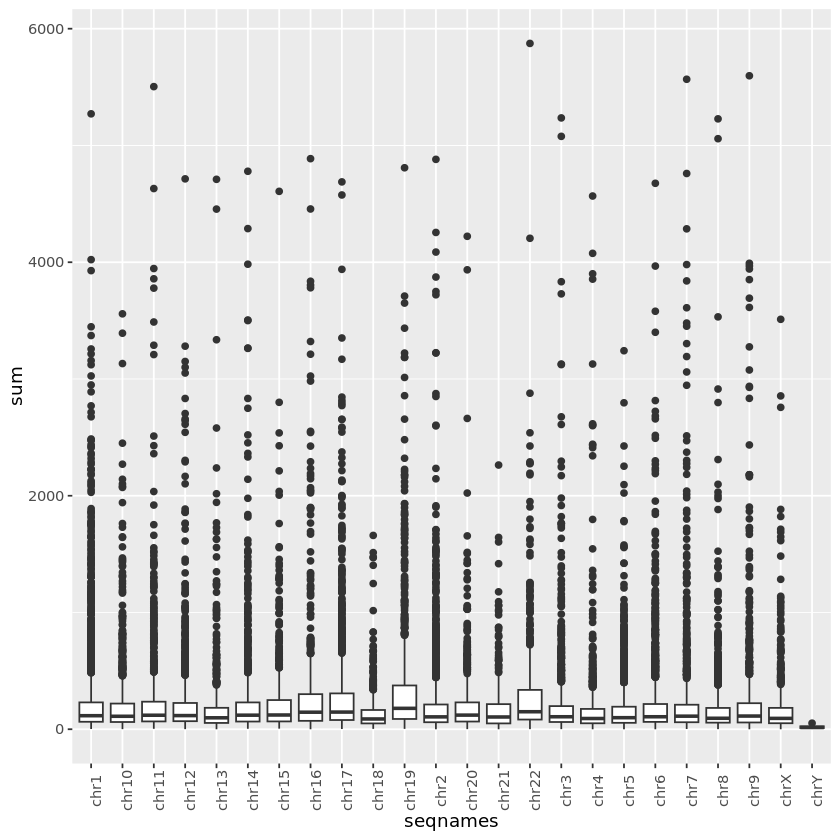

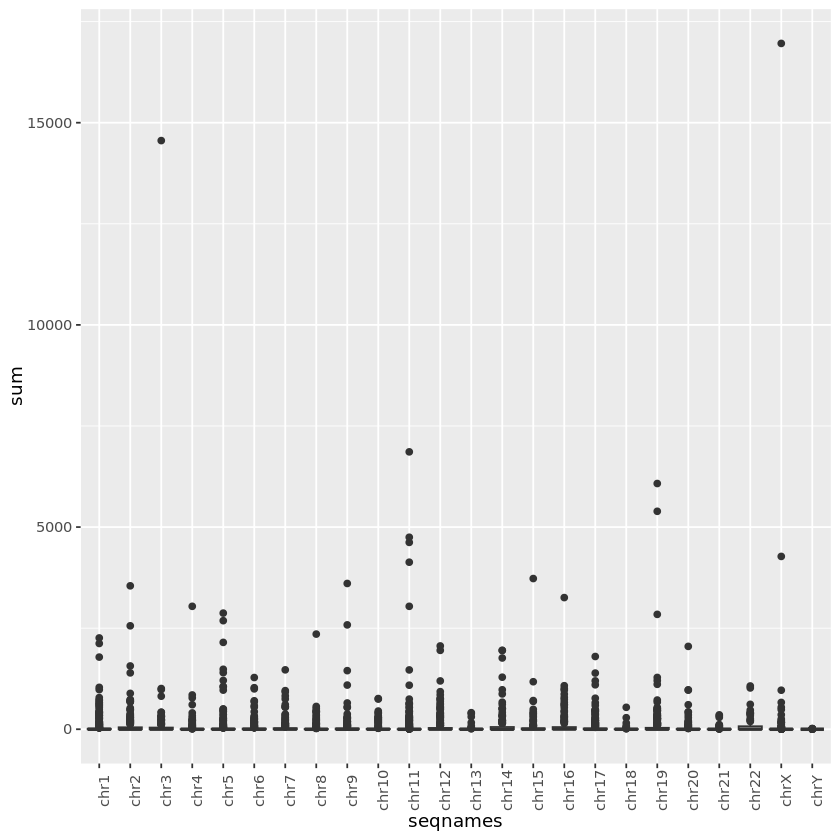

In [32]:
library(ggplot2)
# Distribution of unmerged ATAC peaks by chromosome
ggplot(as.data.frame(unmerged_atac), aes(x=seqnames, y=sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

# Distribution of unassociated gene expression by chromosome
ggplot(as.data.frame(genes_with_no_peak), aes(x=seqnames, y=sum)) + 
  geom_boxplot() + theme(axis.text.x = element_text(angle=90))

# Step 8: Visualization

* Generate a scatter plot using ggplot2:
    * X-axis: log-transformed expression CPM
    * Y-axis: log-transformed ATAC CPM
* If the plot is too much busy of data divide the plot in the 24 chromosomes

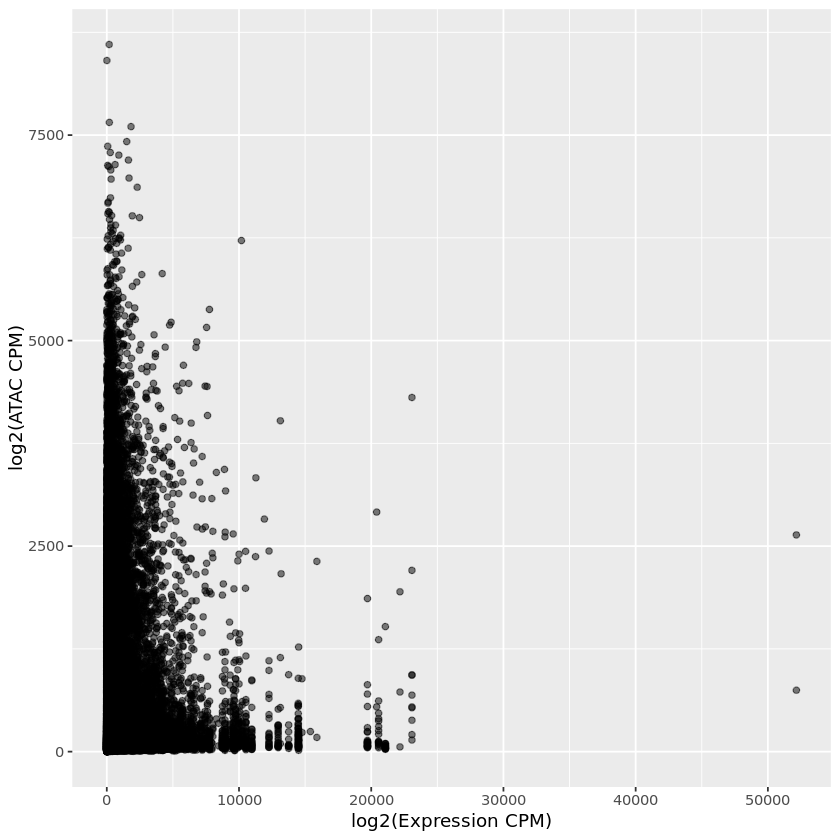

In [33]:
ggplot(merged[!is.na(peak_sum)], aes(x=expr, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)")

In [34]:
head(merged)

gene_id,gene_symbol,expr,peak_sum
<chr>,<chr>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,0,108
ENSG00000000005,TNMD,0,NA
ENSG00000000419,DPM1,424,NA
ENSG00000000457,SCYL3,215,190
ENSG00000000457,SCYL3,215,3340
ENSG00000000460,FIRRM,365,252


In [35]:
names(merged)

[1] "gene_id"     "gene_symbol" "expr"        "peak_sum"

In [36]:
# Extract chromosome info from gr_genes
genes_chr <- data.frame(
  gene_id = gr_genes$gene_id,
  chr = as.character(GenomicRanges::seqnames(gr_genes))
)

In [37]:
# Remove 'chr' column from merged if it exists
if ("chr" %in% colnames(merged)) merged$chr <- NULL

In [38]:
head(genes_chr)

,gene_id,chr
,<chr>,<chr>
1,ENSG00000186092,chr1
2,ENSG00000284733,chr1
3,ENSG00000284662,chr1
4,ENSG00000187634,chr1
5,ENSG00000188976,chr1
6,ENSG00000187961,chr1


In [39]:
# Merge chromosome info into your merged data frame
merged <- merge(
  merged,
  genes_chr,
  by = "gene_id",
  all.x = TRUE
)

In [40]:
head(merged)

gene_id,gene_symbol,expr,peak_sum,chr
<chr>,<chr>,<dbl>,<dbl>,<chr>
ENSG00000000003,TSPAN6,0,108,chrX
ENSG00000000005,TNMD,0,NA,chrX
ENSG00000000419,DPM1,424,NA,chr20
ENSG00000000457,SCYL3,215,190,chr1
ENSG00000000457,SCYL3,215,3340,chr1
ENSG00000000460,FIRRM,365,252,chr1


In [41]:
unique(merged$chr)

[1] "chrX"       "chr20"      "chr1"       "chr6"       "chr3"      
 [6] "chr7"       "chr12"      "chr11"      "chr4"       "chr17"     
[11] "chr2"       "chr16"      "chr8"       "chr19"      "chr9"      
[16] "chr13"      "chr14"      "chr5"       "chr22"      "chr10"     
[21] "chrY"       "chr18"      "chr15"      "chr21"      "unknown"   
[26] "GL000194.1"

In [42]:
nrow(merged)
a <- 55201
sum(merged$chr==merged$chr)

[1] 55256

[1] 55256

In [43]:
nrow(merged[merged$chr == "NA",])

[1] 0

In [44]:
chr_num <- "chr1"
nrow(merged[merged$chr == chr_num,])
nrow(merged[merged$chr == chr_num & !is.na(merged$peak_sum),])

[1] 5310

[1] 4848

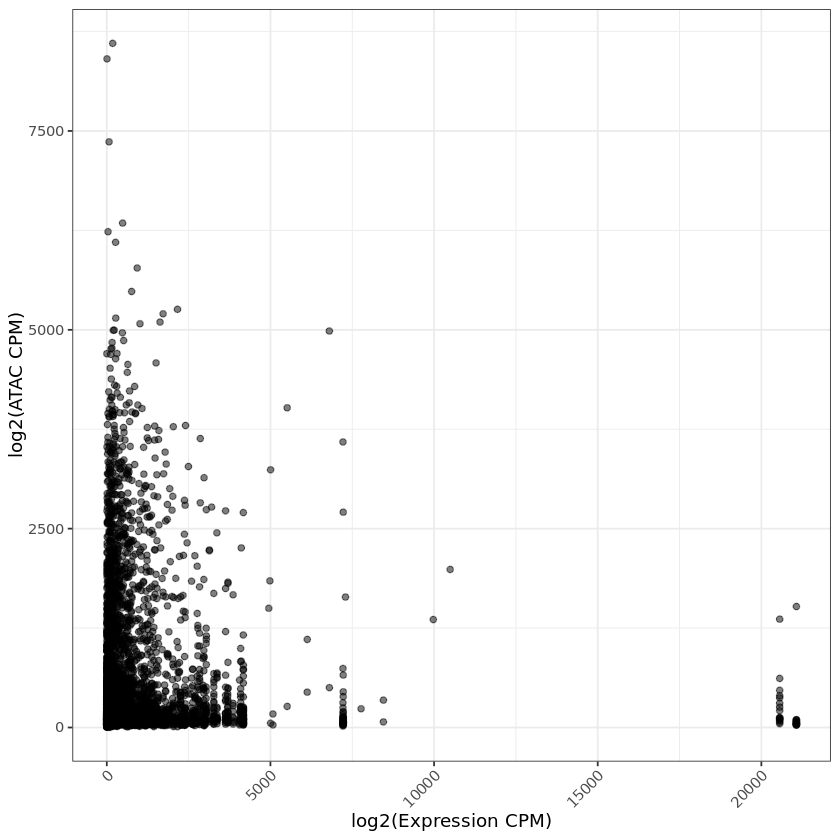

In [45]:
# Then plot as above
ggplot(merged[!is.na(peak_sum) & merged$chr == "chr1"], aes(x=expr, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

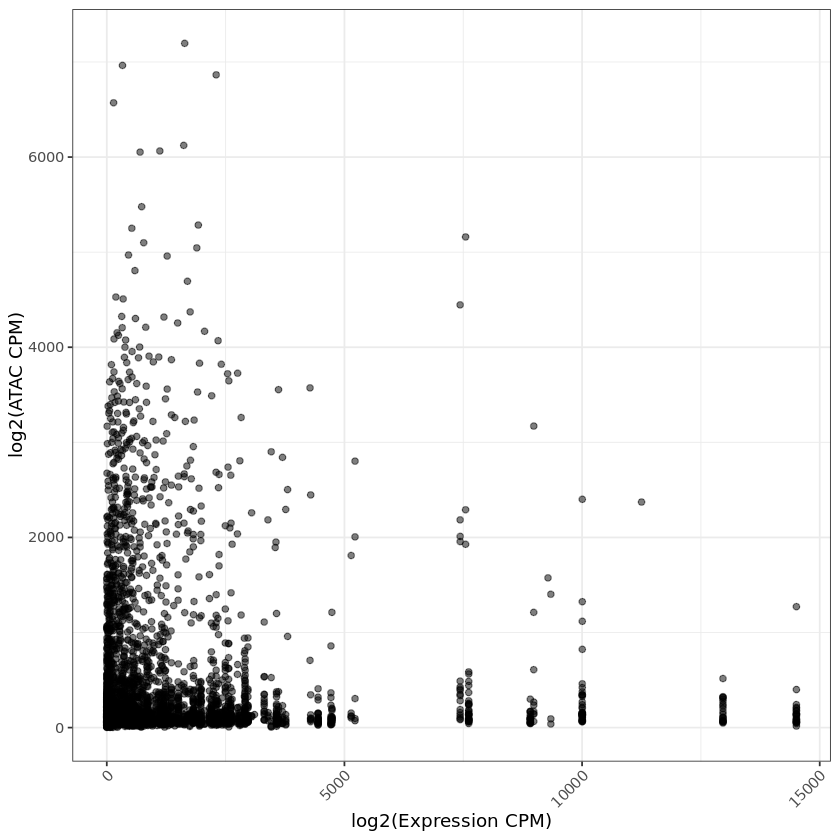

In [46]:
ggplot(merged[!is.na(peak_sum) & merged$chr == "chr2"], aes(x=expr, y=peak_sum)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

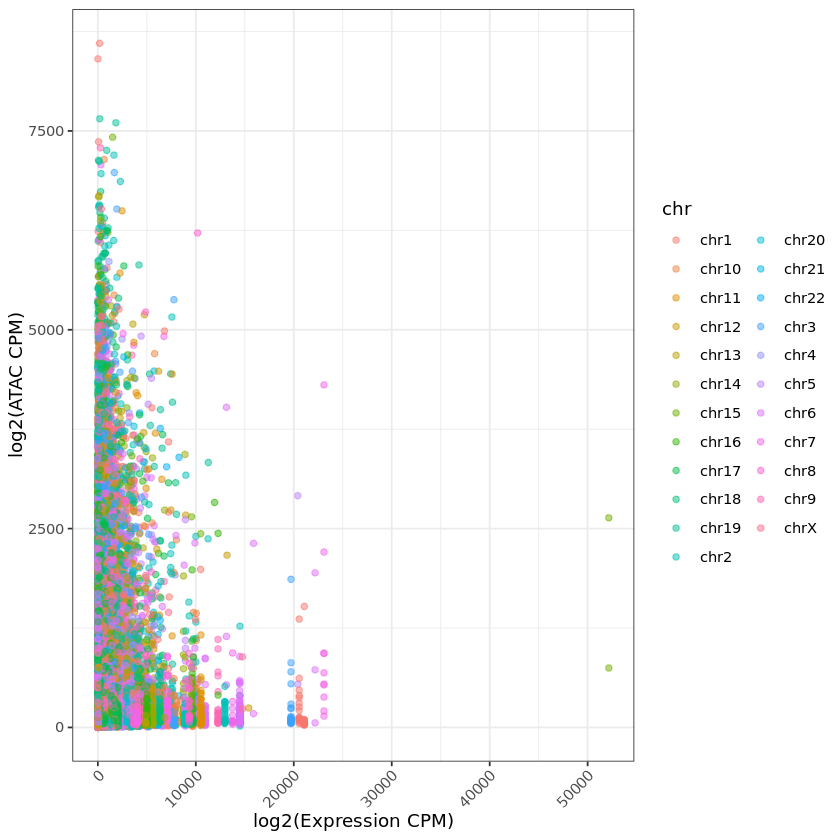

In [47]:
ggplot(merged[!is.na(peak_sum)], aes(x=expr, y=peak_sum, color = chr)) +
  geom_point(alpha=0.5) +
  labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)") +
  #facet_wrap(~ chr) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [48]:
print(paste("a", 1:5))

[1] "a 1" "a 2" "a 3" "a 4" "a 5"


In [49]:
p <- function(chr_num) {
    plot <- ggplot(merged[!is.na(peak_sum) & merged$chr == paste0("chr", chr_num)], aes(x=expr, y=peak_sum)) +
      geom_point(alpha=0.5) +
      labs(x = "log2(Expression CPM)", y = "log2(ATAC CPM)", title = paste0("plot for chr", chr_num)) +
      #facet_wrap(~ chr) +
      theme_bw() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(plot)
}

In [50]:
plot.list <- lapply(c(as.character(1:22), "X", "Y"), p)

In [51]:
c(as.character(1:3), "X", "Y")

[1] "1" "2" "3" "X" "Y"

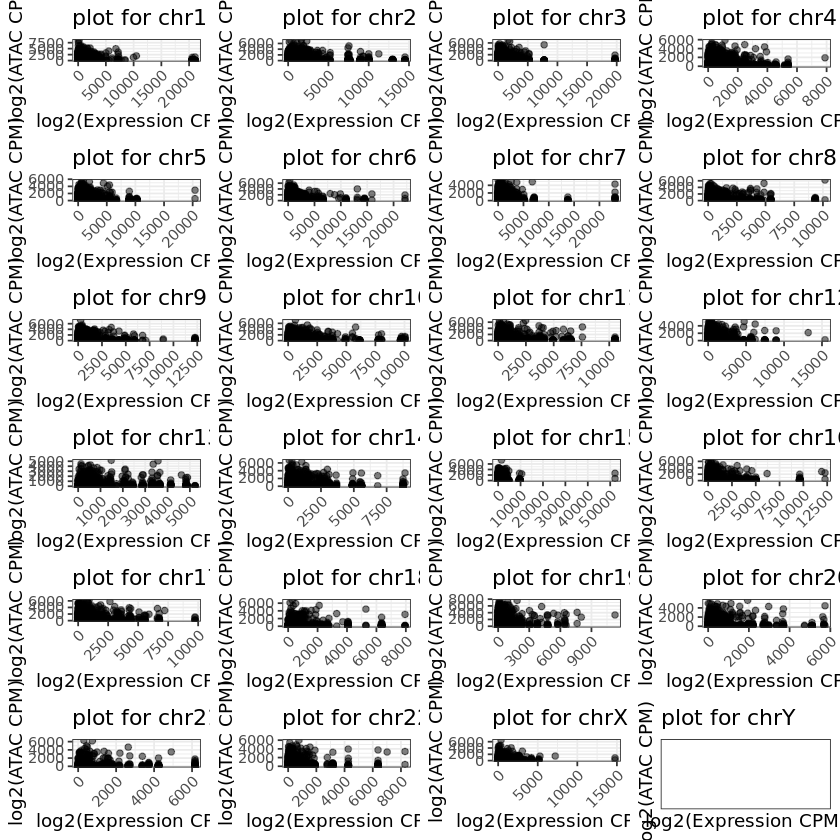

In [52]:
combined <- cowplot::plot_grid(plotlist = plot.list, ncol = 4) 
print(combined)

In [81]:
ggsave("plot.png", plot = combined, width = 1920*2, height = 1080*3.6, units = "px")
# non si vede nulla, troppo piccolo

# R Markdown

In [82]:
#install.packages("tinytex")
#tinytex::install_tinytex()

In [57]:
rmarkdown::render("Maiolino_Au.Rmd")



processing file: Maiolino_Au.Rmd



1/30                   
2/30 [unnamed-chunk-1] 
3/30                   
4/30 [unnamed-chunk-2] 
5/30                   
6/30 [unnamed-chunk-3] 
7/30                   
8/30 [unnamed-chunk-4] 
9/30                   
10/30 [unnamed-chunk-5] 
11/30                   
12/30 [unnamed-chunk-6] 
13/30                   
14/30 [unnamed-chunk-7] 
15/30                   
16/30 [unnamed-chunk-8] 
17/30                   
18/30 [unnamed-chunk-9] 
19/30                   
20/30 [unnamed-chunk-10]
21/30                   
22/30 [unnamed-chunk-11]
23/30                   
24/30 [unnamed-chunk-12]
25/30                   
26/30 [unnamed-chunk-13]
27/30                   
28/30 [unnamed-chunk-14]
29/30                   
30/30 [unnamed-chunk-15]


output file: Maiolino_Au.knit.md




/usr/bin/pandoc +RTS -K512m -RTS Maiolino_Au.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output Maiolino_Au.tex --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --table-of-contents --toc-depth 2 --highlight-style tango --pdf-engine pdflatex --variable graphics --include-in-header /tmp/RtmpoIDjGB/rmarkdown-str8a625e92fe1.html --variable 'geometry:margin=1in' 



Output created: Maiolino_Au.pdf

